<a href="https://colab.research.google.com/github/Andrey239/ML_LPI_2021/blob/main/seminar10/MLatFIAN_2021_seminar10_Intro_to_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutions

In [24]:
!wget https://github.com/HSE-LAMBDA/MLatFIAN2021/raw/main/seminar10/img.npy

--2021-12-19 18:55:33--  https://github.com/HSE-LAMBDA/MLatFIAN2021/raw/main/seminar10/img.npy
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HSE-LAMBDA/MLatFIAN2021/main/seminar10/img.npy [following]
--2021-12-19 18:55:33--  https://raw.githubusercontent.com/HSE-LAMBDA/MLatFIAN2021/main/seminar10/img.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960128 (938K) [application/octet-stream]
Saving to: ‘img.npy.1’

img.npy.1           100%[===================>] 937.62K  --.-KB/s    in 0.05s   

2021-12-19 18:55:33 (18.8 MB/s) - ‘img.npy.1’ saved [960128/960128]



In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Demonstration: convolving to extract features

Let's check out the image we have:

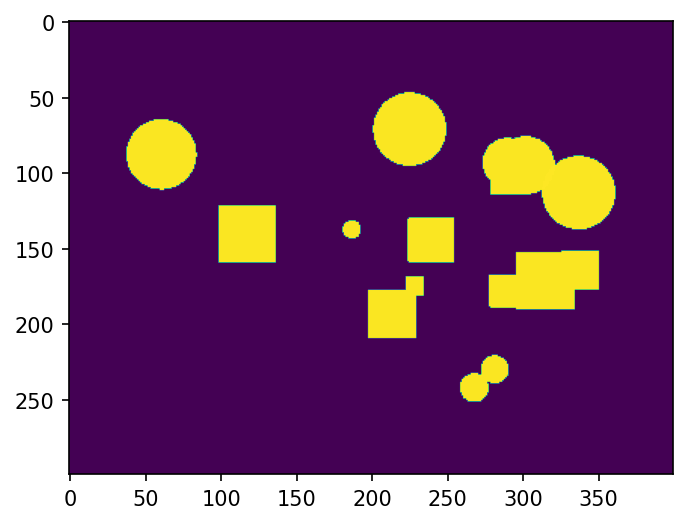

In [26]:
img = np.load("img.npy")

plt.figure(dpi=150)
plt.imshow(img);

At first, we'll experiment with `tf.nn.conv2d` - the function that performs 2d image convolution.

*Note:* this function is designed to work in the context of a neural network (i.e. where input and output come in batches and have multiple channels), so the function expects 4D tensors rather than 2D. We'll write a short wrapper to work with 2D images.

In [27]:
def convolve(img, kernel):
  return tf.nn.conv2d(
      img[None,...,None],
      kernel[...,None,None], strides=1, padding='VALID'
    ).numpy().squeeze()

Let's try some simple kernels extracting horizontal and vertical edges:

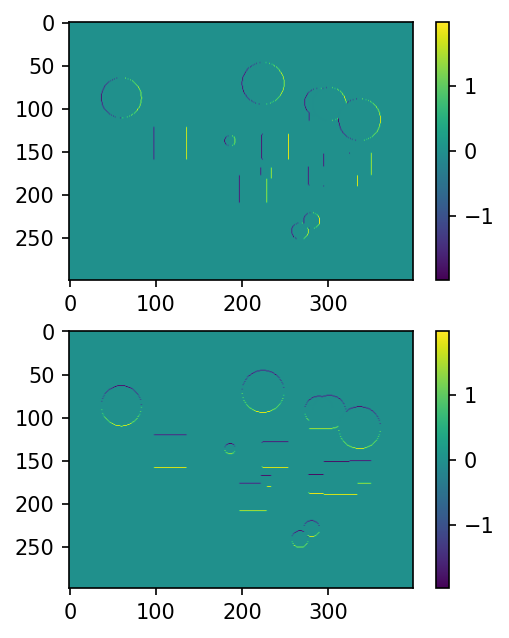

In [28]:
kernel_ver_edge = tf.convert_to_tensor(
    [[ 1., -1.],
     [ 1., -1.]]
)
kernel_hor_edge = tf.convert_to_tensor(
    [[ 1.,  1.],
     [-1., -1.]]
)

vertical_edges = convolve(img, kernel_ver_edge)
horizontal_edges = convolve(img, kernel_hor_edge)

plt.figure(figsize=(4, 5), dpi=150)
plt.subplot(2, 1, 1)
plt.imshow(vertical_edges);
plt.colorbar()
plt.subplot(2, 1, 2)
plt.imshow(horizontal_edges);
plt.colorbar();

We can combine the result, e.g. like this:

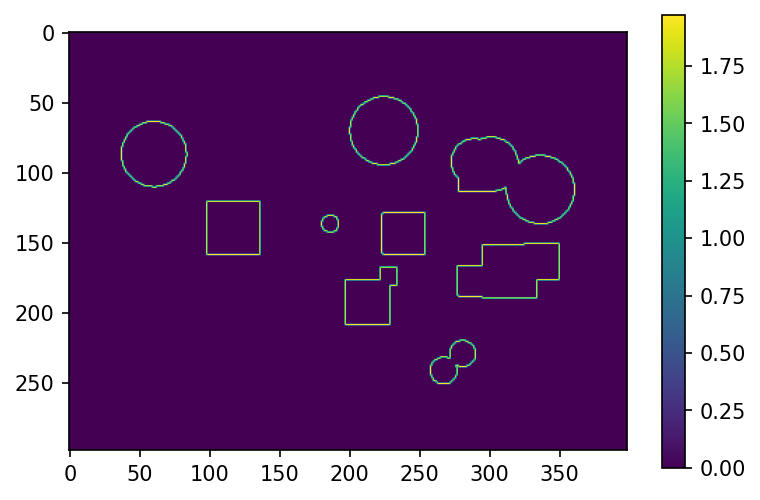

In [29]:
edges = (vertical_edges**2 + horizontal_edges**2)**0.5
plt.figure(dpi=150)
plt.imshow(edges)
plt.colorbar();

Another example, blurring kernel:

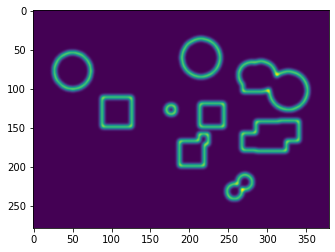

In [30]:
def blur_n_times(img, n=5):
    assert n >= 1
    kernel_blur = tf.convert_to_tensor([[1.,  4.,  7.,  4., 1.],
                                        [4., 16., 26., 16., 4.],
                                        [7., 26., 41., 26., 7.],
                                        [4., 16., 26., 16., 4.],
                                        [1.,  4.,  7.,  4., 1.]]) / 273

    img_blurred = convolve(img, kernel_blur)

    for _ in range(n - 1):
        img_blurred = convolve(img_blurred, kernel_blur)
    return img_blurred

edges_blurred = blur_n_times(edges, n=5)
plt.imshow(edges_blurred);

Let's pick up a small patch out of this image:

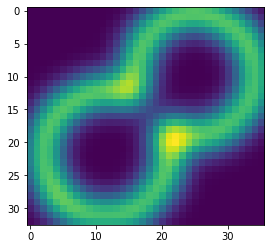

In [31]:
edges_blurred = blur_n_times(edges, n=5)
edges_subset = edges_blurred[210:243, 246:282]
plt.imshow(edges_subset);

What do you think will happen if we use this patch as a kernel when running convolution on the edges image?

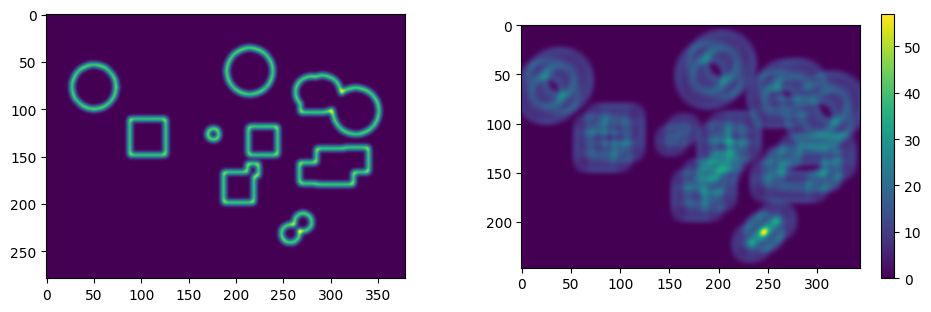

In [32]:
plt.figure(figsize=(12, 3.5), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(edges_blurred)
plt.subplot(1, 2, 2)
plt.imshow(convolve(edges_blurred, edges_subset))
plt.colorbar();

Note how this kernel highlighted the location of that shape on the input!

## Convolutional layer

Keras has predefined convolutional layers that make use of the convolution function described above.

Note that in the context of deep learning the convolutional kernel is **trainable**, i.e. the network tries to find the best kernel to extract useful features.

In [33]:
# Let's build a layer that takes an image with a single channel and outputs 
# two-channel feature representation:
conv_layer = tf.keras.layers.Conv2D(
    filters=2, kernel_size=2)
conv_layer.build(input_shape=(None, None, 1))

Note that the kernel is initialized randomly (for optimization):

In [34]:
conv_layer.kernel

<tf.Variable 'kernel:0' shape=(2, 2, 1, 2) dtype=float32, numpy=
array([[[[-0.06037432, -0.6560474 ]],

        [[-0.577749  ,  0.08575284]]],


       [[[ 0.43557483, -0.4656532 ]],

        [[ 0.06733936,  0.28885007]]]], dtype=float32)>

but we can set it to e.g. our edge detecting kernel values:

In [35]:
conv_layer.kernel[..., 0, 0].assign(kernel_hor_edge)
conv_layer.kernel[..., 0, 1].assign(kernel_ver_edge)
conv_layer.kernel

<tf.Variable 'kernel:0' shape=(2, 2, 1, 2) dtype=float32, numpy=
array([[[[ 1.,  1.]],

        [[ 1., -1.]]],


       [[[-1.,  1.]],

        [[-1., -1.]]]], dtype=float32)>

And now the layer performs exactly the same edge-detecting operation:

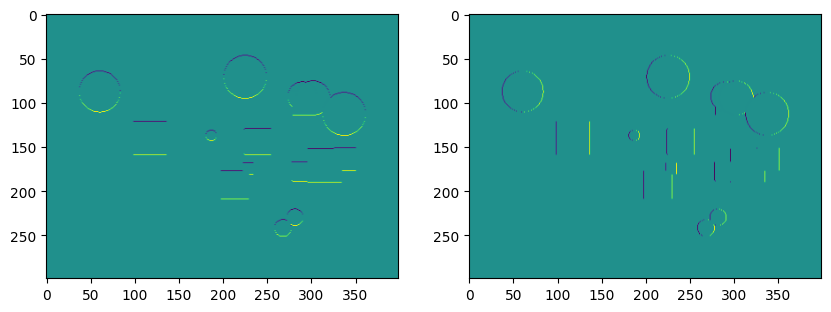

In [36]:
# Note how we add the batch and channel dimensions here
result = conv_layer(img[None,...,None].astype('float32')).numpy().squeeze()

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(result[...,0])
plt.subplot(1, 2, 2)
plt.imshow(result[...,1]);

## Ridiculously impractical example: trying to learn the kernels from the 1st demo

Let's make a keras model that make a similar transformation to the one we did above (i.e. edge detection + blur). We'll try to learn corresponding kernels.

In [37]:
model = tf.keras.Sequential(
    [
      # a block to "reproduce" edge detection:
      tf.keras.layers.Conv2D(filters=2, kernel_size=2, activation='elu'),
 
      tf.keras.layers.Conv2D(filters=100, kernel_size=1, activation='elu'),
      tf.keras.layers.Conv2D(filters=1, kernel_size=1, activation='elu'),

      # a block to "reproduce" blurring
      tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='elu'),
      tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='elu'),
      tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='elu'),
      tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='elu'),
      tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='elu'),
      tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='elu'),
      tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='elu'),
      tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='elu'),
      tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='elu'),
      tf.keras.layers.Conv2D(filters=1, kernel_size=3, activation='elu'),
    ]
)
model.build(input_shape=(None, None, None, 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, None, None, 2)     10        
                                                                 
 conv2d_28 (Conv2D)          (None, None, None, 100)   300       
                                                                 
 conv2d_29 (Conv2D)          (None, None, None, 1)     101       
                                                                 
 conv2d_30 (Conv2D)          (None, None, None, 4)     40        
                                                                 
 conv2d_31 (Conv2D)          (None, None, None, 4)     148       
                                                                 
 conv2d_32 (Conv2D)          (None, None, None, 4)     148       
                                                                 
 conv2d_33 (Conv2D)          (None, None, None, 4)    

Note: we have quite a lot of parameters and just a single image - we'll probably overfit heavily...

100%|██████████| 500/500 [00:18<00:00, 26.94it/s]


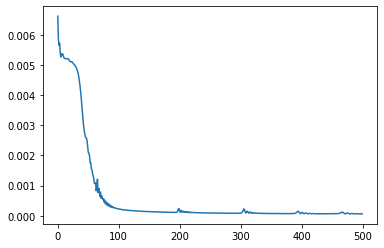

In [38]:
from tqdm import trange

opt = tf.optimizers.Adam()

loss_values = []
for _ in trange(500):
  with tf.GradientTape() as t:
    prediction = model(img[None,...,None].astype('float32'))
    loss = tf.reduce_mean((prediction - edges_blurred[None,...,None])**2)
  grads = t.gradient(loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))
  loss_values.append(loss.numpy())

plt.plot(loss_values);

Let's have a look on what the result of our model's transformation is:

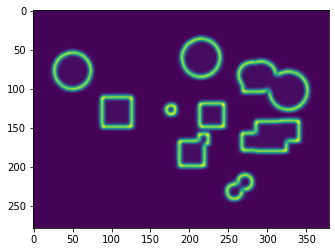

In [39]:
plt.imshow(model(img[None,...,None].astype('float32')).numpy().squeeze());

Try checking the following things:
 - Do the first layers indeed extract the edges?
 - What the intermediate representations of our model look like? (e.g. take the input and only apply a subset of layers from our model to it)


## Deep CNN to classify images

Let's work with the dataset from the previous seminar

[['Pullover' 'Trouser' 'Bag' 'Coat' 'Trouser']
 ['Ankle boot' 'Pullover' 'Pullover' 'T-shirt/top' 'Pullover']
 ['Shirt' 'Ankle boot' 'T-shirt/top' 'Sneaker' 'Sandal']
 ['Coat' 'T-shirt/top' 'Trouser' 'Bag' 'T-shirt/top']
 ['Coat' 'Pullover' 'Shirt' 'Sneaker' 'T-shirt/top']]


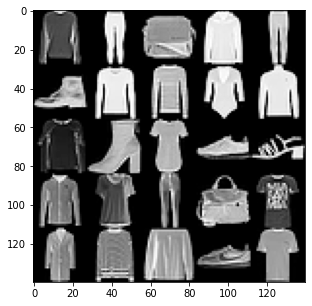

In [40]:
import tensorflow_datasets as tfds

data_train = tfds.load(name="fashion_mnist", split="train").prefetch(60000).cache()
data_test  = tfds.load(name="fashion_mnist", split="test" ).prefetch(10000).cache()

# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 25 images
sample_data = next(iter(data_train.batch(25)))
sample_images = sample_data['image']
sample_labels = sample_data['label']

# Plot the images in a 5x5 grid
plt.figure(figsize=(5, 5))
plt.imshow(
    sample_images.numpy().reshape(5, 5, 28, 28).transpose((0, 2, 1, 3)).reshape(140, 140),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(5, 5)])

Fill the gaps below to build a convolutional neural network and classify the images.

Some hints for classes:
 - `tf.keras.layers.Conv2D` - convolutional layer
 - `tf.keras.layers.MaxPool2D` - maxpool layer
 - `tf.keras.layers.BatchNormalization` - batchnorm layer
 - `tf.keras.layers.Dropout` - dropout layer
 - `tf.keras.layers.Reshape` - reshaping layer (to convert the image-like representation to a vector-like representation deep down in the network

Try to follow the general deep convolutional architecture:
 - combine convolutions with maxpoolings to reduce the spacial size of the representation
 - increase the number of filters as you go deeper
 - when the spacial size of your representation is small enough (1-2 pixels), convert (reshape) it to a vector and then use fully connected layers

In [41]:
print(data_train)

<CacheDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


In [51]:
def build_model(use_batchnorm, dropout_rate):
  """
  Fill in the layers below.

  If use_batchnorm is True, add a batchnorm layer to **every** convolution and
  dense layer (except for the output one).
  If dropout_rate > 0, add a dropout layer with `rate=dropout_rate` to **every**
  convolution and dense layer (except for the output one).
  """
  layers = []
  
  filters= [4,10,50,100]
  kernel=[3,2,3,1]
  for j in range(4):
      layers.append(tf.keras.layers.Conv2D(filters[j], kernel[j]))
      if use_batchnorm:
        layers.append(tf.keras.layers.BatchNormalization())
      layers.append(tf.keras.layers.Activation("elu"))
      if (dropout_rate > 0):
        layers.append(tf.keras.layers.Dropout(dropout_rate))
      layers.append(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
  
  
  
  layers.append(tf.keras.layers.Reshape(target_shape=(100,), input_shape=(1,1,100)))
  
  dense=[64,32,16]
  for j in range(3):
    layers.append(tf.keras.layers.Dense(dense[j]))
    if use_batchnorm:
      layers.append(tf.keras.layers.BatchNormalization())
    layers.append(tf.keras.layers.Activation("relu"))
    if (dropout_rate > 0):
      layers.append(tf.keras.layers.Dropout(dropout_rate))
  

  layers.append(tf.keras.layers.Dense(10))

  model = tf.keras.Sequential(layers)
  model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.metrics.SparseCategoricalAccuracy()])
  return model

In [52]:
configs = [
  dict(use_batchnorm=False, dropout_rate=0),
  dict(use_batchnorm=False, dropout_rate=0.01),
  dict(use_batchnorm=False, dropout_rate=0.05),
  dict(use_batchnorm=False, dropout_rate=0.5),
  dict(use_batchnorm=True, dropout_rate=0),
  dict(use_batchnorm=True, dropout_rate=0.01),
  dict(use_batchnorm=True, dropout_rate=0.05),
  dict(use_batchnorm=True, dropout_rate=0.5)
]

models = {str(configi) : build_model(**configi) for configi in configs}

In [53]:
batch_size = 512

def preprocess(x):
  return (tf.cast(x['image'], 'float32') / 255., x['label'])

for config, model in models.items():
  print("Working on model:", config)
  model.fit(x=data_train.map(preprocess).shuffle(60000).batch(batch_size), epochs=10,
            validation_data=data_test.map(preprocess).batch(4096))

Working on model: {'use_batchnorm': False, 'dropout_rate': 0}
Epoch 1/10
118/118 [==============================] - 16s 36ms/step - loss: 1.2706 - sparse_categorical_accuracy: 0.5560 - val_loss: 0.8497 - val_sparse_categorical_accuracy: 0.7023
Epoch 2/10
118/118 [==============================] - 5s 20ms/step - loss: 0.7565 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7149 - val_sparse_categorical_accuracy: 0.7326
Epoch 3/10
118/118 [==============================] - 5s 20ms/step - loss: 0.6562 - sparse_categorical_accuracy: 0.7573 - val_loss: 0.6534 - val_sparse_categorical_accuracy: 0.7446
Epoch 4/10
118/118 [==============================] - 5s 19ms/step - loss: 0.5916 - sparse_categorical_accuracy: 0.7837 - val_loss: 0.6288 - val_sparse_categorical_accuracy: 0.7546
Epoch 5/10
118/118 [==============================] - 5s 19ms/step - loss: 0.5454 - sparse_categorical_accuracy: 0.8013 - val_loss: 0.5448 - val_sparse_categorical_accuracy: 0.8028
Epoch 6/10
118/118 [============

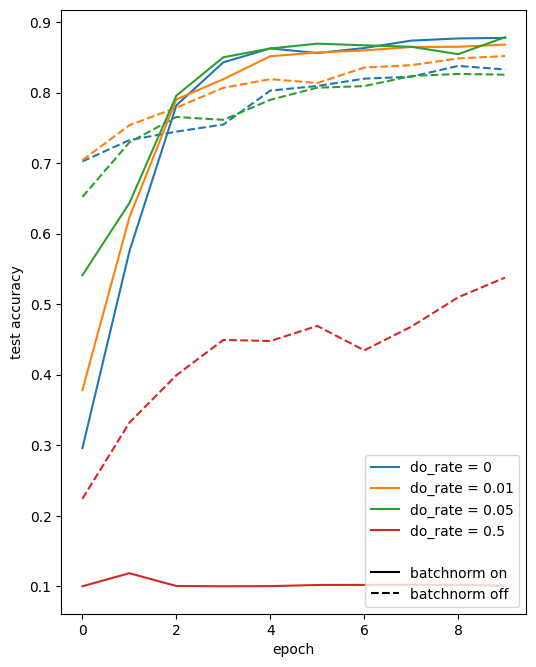

In [54]:
plt.figure(figsize=(6, 8), dpi=100)
color_cycle = iter(plt.rcParams['axes.prop_cycle'])
#i got pretty bored waiting for results, nlg
colors = {}

lines = []
labels = []
for config, model in models.items():
  config = eval(config)
  if config['dropout_rate'] not in colors:
    colors[config['dropout_rate']] = next(color_cycle)

  color = colors[config['dropout_rate']]['color']

  style = '-' if config['use_batchnorm'] else '--'
  line, = plt.plot(model.history.history['val_sparse_categorical_accuracy'], style,
                   c=color)
  
  if config['use_batchnorm']:
    lines.append(line)
    labels.append(f"do_rate = {config['dropout_rate']}")

plt.xlabel("epoch")
plt.ylabel("test accuracy");

from matplotlib.lines import Line2D

lines += [Line2D([0], [0], linestyle='-', color='w'),
          Line2D([0], [0], linestyle='-', color='k'),
          Line2D([0], [0], linestyle='--', color='k')]
labels += ['', 'batchnorm on', 'batchnorm off']
plt.legend(lines, labels);